# Test notebook for functional regression

## Importing

In [47]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale


import skfda
from skfda.ml.regression import KNeighborsRegressor
from skfda.representation.basis import FourierBasis

from skfda.representation.grid import FDataGrid

from skfda.ml.clustering import FuzzyCMeans, KMeans

## Files Reading

In [57]:
# The location of the file
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')

# ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
#     y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# Selecting the first 2 years
dataset = ds.sel(time_counter = slice('2007-2-15', '2020-4-30'))
dates = pd.DatetimeIndex(dataset['time_counter'].values)


## Datasets Preparation

In [ ]:
test = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    ])

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test = test[:,:,indx[0]]

test = np.transpose(test,axes=(0,2,1))

# test[0] = minmax_scale(test[0])
# test[1] = minmax_scale(test[1])
test.shape

In [64]:
test1 = np.reshape(np.ravel(dataset['Flagellate']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
test2 = np.reshape(np.ravel(dataset['Diatom']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(test2).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
test1 = test1[:,indx[0]]
test2 = test2[:,indx[0]]

test1 = test1.transpose()
test2 = test2.transpose()

test1 = minmax_scale(test1)



In [22]:
test1.shape

(1838, 76)

In [65]:
input = FDataGrid(test1)
target = FDataGrid(test2)


In [66]:
target = target.to_basis(FourierBasis(n_basis=5))
test = target.to_grid()


## Training 

In [67]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(test)
clusters = kmeans.predict(test)

In [49]:
clusters.shape

(1838,)

In [68]:
indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
indx2[indx[0]] = clusters
clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

# Preparation of the dataarray 
clusters= xr.DataArray(clusters,
    coords = {'y': dataset.y, 'x': dataset.x},
    dims = ['y','x'],
    attrs=dict(description="Clusters of the performed self organizing map algorithm",
    long_name ="Cluster",
    units="count"),)

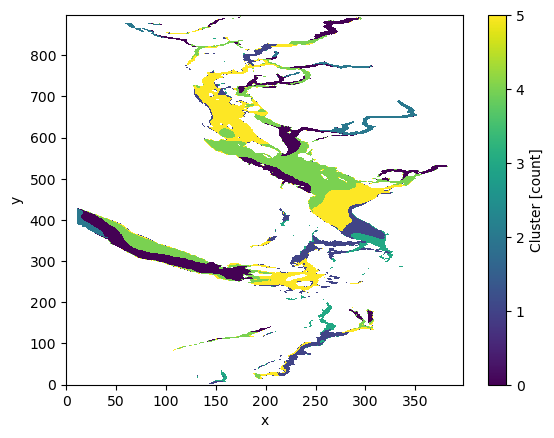

In [69]:
clusters.plot()

In [ ]:
clusters.plot()

In [ ]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

In [ ]:
input = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    # np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    # np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    # np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    # np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    # np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
    ])

x =  np.tile(dataset.x, len(dataset.y))
y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

indx = np.where((~np.isnan(input[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880))) # input[1] because this variable is down to 100m
input =input[:,:,indx[0]]

input = np.transpose(input,axes=(0,2,1)) # this is the right shape for preprocessing the data

# Transforming each variable individually
input[0] = minmax_scale(input[0])
input[1] = minmax_scale(input[1])
# input[2] = minmax_scale(input[2])
# input[3] = minmax_scale(input[3])
# input[4] = minmax_scale(input[4])
# input[5] = minmax_scale(input[5])
# input[6] = minmax_scale(input[6])

# Converting it to an appropriate format for functional clustering
input = np.transpose(input,axes=(1,2,0)) # this is the right shape for converting it to a functional variable
input2 = FDataGrid(input)



In [ ]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(input2)
clusters = kmeans.predict(input2)

In [ ]:
np.where(np.isnan(input))